<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# AT&T SPAM detector

## Présentation de l’entreprise 📇

AT&T Inc. est une entreprise multinationale américaine de télécommunications, dont le siège est situé à la Whitacre Tower, dans le centre-ville de Dallas, au Texas.  
C’est la plus grande entreprise de télécommunications au monde en termes de chiffre d’affaires et le troisième plus grand fournisseur de services de téléphonie mobile aux États-Unis.  

En 2022, AT&T était classée **13ᵉ** au classement Fortune 500 des plus grandes entreprises américaines, avec un chiffre d’affaires de **168,8 milliards de dollars** 😮

---

## Projet 🚧

L’un des principaux points de douleur rencontrés par les utilisateurs d’AT&T est leur exposition constante aux **messages SPAM**.

AT&T a, pendant un temps, été capable de signaler manuellement les messages indésirables, mais l’entreprise recherche désormais une **solution automatisée** permettant de détecter les spams afin de mieux protéger ses utilisateurs.

---

## Objectifs 🎯

Ton objectif est de construire un **détecteur de spam** capable de signaler automatiquement les messages indésirables au moment où ils arrivent, en se basant **uniquement sur le contenu des SMS**.

---


## Périmètre du projet 🖼️

Pour commencer, AT&T souhaite que tu utilises le jeu de données suivant :

[Télécharger le jeu de données](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

---


In [1]:
#%cd Data
#%pwd
#!wget https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv
#%cd ..


## Aides 🦮

Pour t’aider à mener ce projet à bien, voici quelques conseils utiles :

### Commencer simplement

Un bon modèle de deep learning n’a pas nécessairement besoin d’être extrêmement complexe !

### Transfer learning

Tu n’as pas accès à une très grande quantité de données. Exploiter la puissance d’un modèle plus sophistiqué, entraîné sur des milliards d’observations, pourrait donc être une bonne approche.

---

## Livrables 📬

Pour valider ce projet, ton équipe devra :

- Rédiger un notebook qui effectue le prétraitement des données et entraîne un ou plusieurs modèles de deep learning afin de prédire si un SMS est un spam ou non (ham)
- Présenter clairement les performances obtenues

&nbsp;

---



## Processus envisagé pour le projet : AT&T

Pour un projet comme AT&T, le déroulement pourrait être le suivant :

- [x] Trouver un bon modèle LLM capable de gérer la détection de spam  
- [x] L’entraîner et l’améliorer à l’aide des données disponibles  
- [x] Tester et comparer les performances avec les meilleurs modèles disponibles sur Hugging Face  

---

## Objectifs concrets

### Quels outils dois-tu utiliser ?

- Lightning AI et Google Colab pour l’entraînement et le fine-tuning des modèles

### Quels processus dois-tu mettre en place ?

- Sélection d’un modèle pré-entraîné  
- Fine-tuning du ou des modèles  
- Évaluation des performances  

### À quelles questions dois-tu répondre ?

- Spam ou ham ? Telle est la question.

### Quels problèmes dois-tu résoudre ?

- Nettoyage et préparation des données  
- Fine-tuning du modèle  

### Quels fichiers spécifiques dois-tu rendre pour la certification ?

- Un notebook  
- Un court rapport présentant les résultats de l’évaluation des modèles


In [2]:
# if use of google colab
#from google.colab import drive
#drive.mount('/content/drive')

# Rendu


In [3]:
pip install datasets transformers evaluate rouge_score -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install numpy
%pip install 'accelerate>=0.26.0'
%pip install  scikit-learn
%pip install plotly 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from transformers import pipeline,TrainingArguments,Trainer,EvalPrediction, EarlyStoppingCallback
TRANSFORMERS_AVAILABLE = True
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    accuracy_score
)
import matplotlib.pyplot as plt

import plotly.express as px


In [6]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
#ROOT_DIR="/content/drive/MyDrive/Colab Notebooks/Jedha/dsfs-ft-35/att"
ROOT_DIR="."
LENGTH=64

Toilettage du fichier pour retirer les caractères invalides qui nuisent à l'execution du notebook.

In [8]:
import unicodedata

def clean_international_text(text):
    # Normalize Unicode characters
    normalized = unicodedata.normalize('NFKD', text)
    # Remove non-ASCII characters
    ascii_text = normalized.encode('ASCII', 'ignore').decode('ASCII')
    return ascii_text

Archivage dans un fichier nettoyé du dataset propre : _spam_clean.csv_

In [9]:
filenameIn=ROOT_DIR+"/Data/spam.csv"
output=clean_international_text(open(filenameIn, "r",encoding="ISO-8859-1").read())
filename=ROOT_DIR+"/Data/spam_clean.csv"
with open(filename, "w") as f:
    f.write(output)

Reprise dans un dataframe du dataset propre.

In [10]:
spam_df = pd.read_csv(ROOT_DIR+"/Data/spam_clean.csv")#,encoding="ISO-8859-1"

In [11]:
spam_df.shape

(5572, 5)

## Dataset exploration

Nous explorons le jeu de données pour comprendre sa structure par rapport au problème d'analyse de spam qui nous préoccupe.

In [12]:
display(spam_df.head())
display(spam_df.info())
display(spam_df.describe())
display(spam_df.shape)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


None

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


(5572, 5)

La structure est très simple la première colonne _v1_ est la valeur de la cible : HAM-> texto correct ou SPAM-> texto de type pourriel.  
Puis la colonne _v2_, unnamed: 2, unnamed: 3 et unnamed: 4 correspondent au message texto découpé sur 4 colonnes.

# ETL sur le jeu de données de SPAM

Pour rendre plus explicite le dataset, je renomme les colonnes pour que leur contenu soit plus explicite.

In [13]:
#spam_dataset.dropna(inplace=True)
spam_df.rename(columns={ 'v1': 'type','v2': 'line1', 'Unnamed: 2': 'line2','Unnamed: 3': 'line3','Unnamed: 4': 'line4'}, inplace=True)
spam_df.shape

(5572, 5)

Je fusionne les lignes du texto en un unique message.

In [14]:
spam_df['message'] = spam_df[['line1', 'line2', 'line3', 'line4']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
spam_df['message'] =spam_df['message'].apply(lambda x: x.replace('\\', ''))
#spam_dataset['message'] = spam_dataset['line1']

Nous transformons la colonne 'v1' en une colonne binaire 'spam' où 'spam' devient 1 et 'ham' devient 0.

In [15]:
mapping = {
  "spam": 1,
  "ham": 0
}
spam_df["spam"] = spam_df["type"].map(mapping)
spam_df = spam_df[['spam', 'message','type']]
spam_df.shape

(5572, 3)

In [16]:
spam_new_df=spam_df.rename(columns={ 'message': 'text','spam': 'label', 'type': 'label_text'})
spam_new_df.shape

(5572, 3)

## Verification de l'intégration

In [17]:
print(spam_new_df.isnull().sum())
spam_new_df

label         0
text          0
label_text    0
dtype: int64


,label,text,label_text
0,0,"Go until jurong point, crazy.. Available only ...",ham
1,0,Ok lar... Joking wif u oni...,ham
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,0,U dun say so early hor... U c already then say...,ham
4,0,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,spam
5568,0,Will I_ b going to esplanade fr home?,ham
5569,0,"Pity, * was in mood for that. So...any other s...",ham
5570,0,The guy did some bitching but I acted like i'd...,ham


Création des dataframes de test et d'entrainement

In [18]:
spam_train_df, spam_test_df = train_test_split(
    spam_new_df,
    test_size=0.2,
    random_state=42,
    stratify=spam_new_df["label"]
)

train_length=len(spam_train_df)
test_length=len(spam_test_df)
print(f"{train_length} échantillons d'entrainement et {test_length} échantillons de test.")

4457 échantillons d'entrainement et 1115 échantillons de test.


In [19]:
spam_test_df

,label,text,label_text
2826,0,"Oh right, ok. I'll make sure that i do loads o...",ham
3695,0,I am in tirupur. call you da.,ham
3906,0,No that just means you have a fat head,ham
575,1,"You have won ?1,000 cash or a ?2,000 prize! To...",spam
2899,0,Come aftr &lt;DECIMAL&gt; ..now i m cleaning ...,ham
...,...,...,...
854,0,Stop the story. I've told him i've returned it...,ham
5044,0,We have sent JD for Customer Service cum Accou...,ham
2015,0,Just re read it and I have no shame but tell m...,ham
3381,0,"Well, I meant as opposed to my drunken night o...",ham


# Passage dans l'environnement PyTorch et transformers.

## Conversion du DataFrame Pandas en DataSet PyTorch.

Transfert des dataframes Pandas en tenseur Pytorch en séparant les caractéristiques (feature) de la cible (target).

Création du dataset gérant le texte des spams.

In [20]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.texts = dataframe["text"].tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx])
        }


Instanciation du dataset.

In [21]:
checkpoint = "bert-base-uncased"
#checkpoint = "distilbert-base-uncased"
#model_name = 'mrm8488/bert-tiny-finetuned-sms-spam-detection',
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

spam_train_dataset = TextDataset(
    spam_train_df,
    tokenizer=tokenizer,
    max_len=LENGTH
)
spam_test_dataset = TextDataset(
    spam_test_df,
    tokenizer=tokenizer,
    max_len=LENGTH
)

print(spam_train_dataset[0])
print(type(spam_train_dataset[0]))
print(spam_test_dataset[0])
print(type(spam_test_dataset[0]))


{'input_ids': tensor([ 101, 2183, 2006, 2498, 2307, 1012, 9061,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'labels': tensor(0)}
<class 'dict'>
{'input_ids': tensor([  101,  2821,  2157,  1010,  7929,  1012,  1045,  1005,  2222,  2191,
         2469,  2008,  1045,  2079, 15665,  1997,  2147,  2076,  1996,  2154,
          999,  2288,  1037,  2428, 11808, 19340,  2651,  1998,  2003,  4318,
         1050,  2915,  2061,  20

Création du DataLoader pour test et premier model

In [22]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(
    spam_test_dataset,
    batch_size=16,
    shuffle=True
)

for batch in test_dataloader:
    X = batch["input_ids"]
    y = batch["labels"]

train_dataloader = DataLoader(
    spam_train_dataset,
    batch_size=16,
    shuffle=True
)

for batch in train_dataloader:
    X = batch["input_ids"]
    y = batch["labels"]



## Essai modèle Bert

On tente de raffiner le modèle populaire [bert-base-uncased](https://huggingface.co/google-bert/bert-base-uncased).  

### Preprocessing du dataset
Il est nécessaire de convertir le texte en suite de nombres avec un "tokenizer'.
Nous utilisons ici le modèle pré-entraîné DistilBERT qui est la reference du moment en terme de LLM.
A partir de ce modèle, nous allons le fine-tuner sur notre dataset.

### Jeux d'entrainement et de test
Le jeu de données est propre et prêt, il faut maintenant le diviser en un jeu d'entrainement, un jeu de validation et un jeu de test.

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "auc": roc_auc_score(labels, probs[:,1])
    }


In [24]:
# training_args = TrainingArguments("test-trainer", report_to='none')
training_args = TrainingArguments(
    output_dir="./bert_simulator",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    metric_for_best_model="auc",
    greater_is_better=True,
    report_to=None,
    save_total_limit=1
)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,max_length=LENGTH)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [25]:
from transformers import TrainerCallback

class MyCallback(TrainerCallback):

    def on_train_begin(self, args, state, control, **kwargs):
        print("Début de l'entraînement")

    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"Fin epoch {state.epoch}")

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        print("Évaluation:", metrics)

training_args.report_to = []          # désactive tout reporting
# ou: training_args.report_to = ["tensorboard"]
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=spam_train_dataset,
    eval_dataset=spam_test_dataset,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[MyCallback]
)
trainer.train()

Début de l'entraînement


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,No log,0.046976,0.991031,0.996193
2,0.049681,0.051577,0.991031,0.991705
3,0.049681,0.050786,0.991928,0.991510


Fin epoch 1.0
Évaluation: {'eval_loss': 0.0469760037958622, 'eval_accuracy': 0.9910313901345291, 'eval_auc': 0.996192699431684, 'eval_runtime': 3.9783, 'eval_samples_per_second': 280.273, 'eval_steps_per_second': 17.596, 'epoch': 1.0}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Fin epoch 2.0
Évaluation: {'eval_loss': 0.051576677709817886, 'eval_accuracy': 0.9910313901345291, 'eval_auc': 0.9917045312434866, 'eval_runtime': 4.2166, 'eval_samples_per_second': 264.433, 'eval_steps_per_second': 16.601, 'epoch': 2.0}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Fin epoch 3.0
Évaluation: {'eval_loss': 0.05078648403286934, 'eval_accuracy': 0.9919282511210762, 'eval_auc': 0.9915099976378063, 'eval_runtime': 4.252, 'eval_samples_per_second': 262.23, 'eval_steps_per_second': 16.463, 'epoch': 3.0}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=837, training_loss=0.03147428878889004, metrics={'train_runtime': 188.8782, 'train_samples_per_second': 70.792, 'train_steps_per_second': 4.431, 'total_flos': 439757240152320.0, 'train_loss': 0.03147428878889004, 'epoch': 3.0})


### Evaluation

In [26]:
# Calcul des prédictions et de l'évaluation
bert_evaluation = trainer.evaluate(spam_test_dataset)

pred = trainer.predict(spam_test_dataset)
logits = pred.predictions
proba = torch.softmax(torch.tensor(logits), dim=1).numpy()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Évaluation: {'eval_loss': 0.046981148421764374, 'eval_accuracy': 0.9910313901345291, 'eval_auc': 0.9961996470604583, 'eval_runtime': 4.3595, 'eval_samples_per_second': 255.766, 'eval_steps_per_second': 16.057, 'epoch': 3.0}


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Evaluation du modèle : {checkpoint}
{'eval_loss': 0.046981148421764374, 'eval_accuracy': 0.9910313901345291, 'eval_auc': 0.9961996470604583, 'eval_runtime': 4.3595, 'eval_samples_per_second': 255.766, 'eval_steps_per_second': 16.057, 'epoch': 3.0}
 type true <class 'numpy.ndarray'> type score <class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.96      0.97       149

    accuracy                           0.99      1115
   macro avg       0.98      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



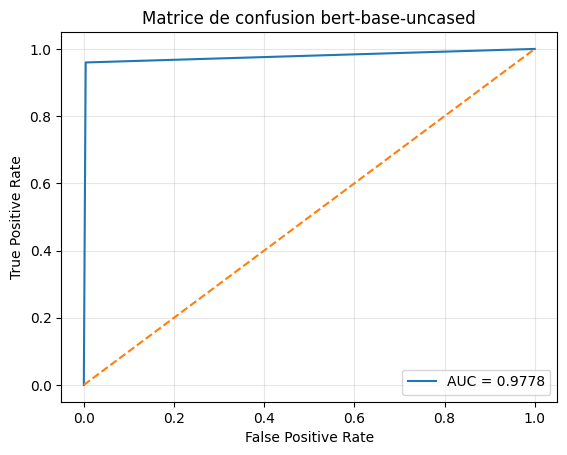

In [28]:

print("Evaluation du modèle : {checkpoint}")
print(bert_evaluation)
# Valeurs de test
y_true=spam_test_df["label"].to_numpy()
# Valeurs prédites associées
y_score = np.argmax(proba, axis=1)
# vérification des types
print(f" type true {type(y_true)} type score {type(y_score)}")
# Rapport
print(classification_report(y_true, y_score))
# Evaluation de cette classification binaire ROC et AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.title(f"Matrice de confusion {checkpoint}")
plt.show()

In [29]:
# Matrice de confusion
cm = pd.DataFrame(confusion_matrix(y_true, y_score),
                  index=['ham', 'spam'],
                  columns=['ham', 'spam'])
px.imshow(cm, text_auto=True)



## Essai d'un second modèle depuis la base Hugging Face


On tente de raffiner le modèle populaire [AventIQ-AI/bert-spam-detection](https://huggingface.co/AventIQ-AI/bert-spam-detection).  


In [30]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
#classifier = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english") Non
checkpoint2 = "AventIQ-AI/bert-spam-detection"
tokenizer2 = BertTokenizer.from_pretrained(checkpoint2)
googletokenizer="google-bert/bert-base-cased"
model2 = BertForSequenceClassification.from_pretrained(checkpoint2)
#model_name = 'mrm8488/bert-tiny-finetuned-sms-spam-detection',
tokenizer2 = AutoTokenizer.from_pretrained(checkpoint2)

spam_train_dataset2 = TextDataset(
    spam_train_df,
    tokenizer=tokenizer,
    max_len=LENGTH
)
spam_test_dataset2 = TextDataset(
    spam_test_df,
    tokenizer=tokenizer,
    max_len=LENGTH
)

print(spam_train_dataset2[0])
print(type(spam_train_dataset2[0]))
print(spam_test_dataset2[0])
print(type(spam_test_dataset2[0]))


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

{'input_ids': tensor([ 101, 2183, 2006, 2498, 2307, 1012, 9061,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'labels': tensor(0)}
<class 'dict'>
{'input_ids': tensor([  101,  2821,  2157,  1010,  7929,  1012,  1045,  1005,  2222,  2191,
         2469,  2008,  1045,  2079, 15665,  1997,  2147,  2076,  1996,  2154,
          999,  2288,  1037,  2428, 11808, 19340,  2651,  1998,  2003,  4318,
         1050,  2915,  2061,  20

In [31]:
training_args2 = TrainingArguments("bert-spam-detection", report_to='none')
print(training_args2)

trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=spam_train_dataset2,
    eval_dataset=spam_test_dataset2,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer2,
)
trainer2.train()

TrainingArguments(
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
enable_jit_checkpoint=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.NO,
eval_use_gather_object=False,

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning:

`max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.



Step,Training Loss
500,0.534097
1000,0.000000
1500,0.000000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning:

`max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning:

`max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning:

`max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=1674, training_loss=0.1595272488064236, metrics={'train_runtime': 108.2065, 'train_samples_per_second': 123.569, 'train_steps_per_second': 15.47, 'total_flos': 439757240152320.0, 'train_loss': 0.1595272488064236, 'epoch': 3.0})

### Evaluation

In [32]:
# Calcul des prédictions et de l'évaluation
bert_spam_detection_evaluation = trainer2.evaluate(spam_test_dataset)

bert_spam_detection_prediction = trainer2.predict(spam_test_dataset)
logits2 = bert_spam_detection_prediction.predictions
proba2 = torch.softmax(torch.tensor(logits2), dim=1).numpy()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning:

`max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.



/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2299: UserWarning:

`max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.



Evaluation du modèle : {checkpoint2}
{'eval_loss': nan, 'eval_accuracy': 0.8663677130044843, 'eval_auc': 0.5052176692094988, 'eval_runtime': 2.1975, 'eval_samples_per_second': 507.398, 'eval_steps_per_second': 63.709, 'epoch': 3.0}
 type true <class 'numpy.ndarray'> type score <class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.96      0.97       149

    accuracy                           0.99      1115
   macro avg       0.98      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



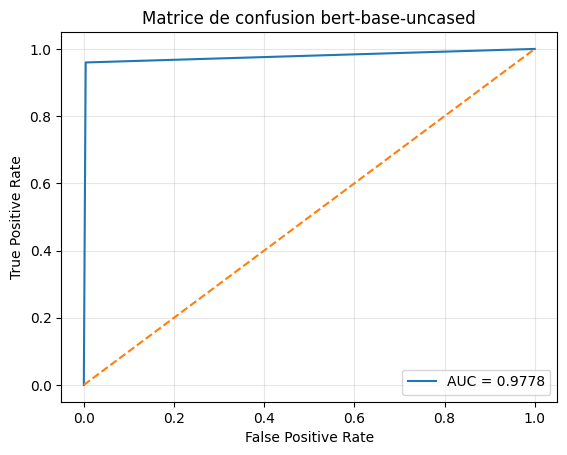

In [33]:

print("Evaluation du modèle : {checkpoint2}")
print(bert_spam_detection_evaluation)
# Valeurs de test
y_true2=spam_test_df["label"].to_numpy()
# Valeurs prédites associées
y_score2 = np.argmax(proba, axis=1)
# vérification des types
print(f" type true {type(y_true2)} type score {type(y_score2)}")
# Rapport
print(classification_report(y_true2, y_score2))
# Evaluation de cette classification binaire ROC et AUC
fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_score2)
roc_auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr2, tpr2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.title(f"Matrice de confusion {checkpoint}")
plt.show()

In [34]:
confusion_matrix(y_true2, y_score2)
cm = pd.DataFrame(confusion_matrix(y_true2, y_score2),
                  index=['ham',  'spam'],
                  columns=['ham',  'spam'])

px.imshow(cm, text_auto=True)

## Troisième modèle : il s'agit d'un modèle fourni par Hugging Face déjà entrainé pour détecter des spams.


Ce modèle s'appuie d'ailleurs encore sur le modèle de langage généraliste de Goggle BERT. Il s'agit du modèle ["mrm8488/bert-tiny-finetuned-sms-spam-detection"](https://huggingface.co/mrm8488/bert-tiny-finetuned-sms-spam-detection)

In [35]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
checkpoint3="mrm8488/bert-tiny-finetuned-sms-spam-detection"
#classifier = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english") Non
classifier = pipeline("text-classification", model=checkpoint3)
spam_preds = classifier(spam_test_df['text'].to_list())
map={'LABEL_0': 0, 'LABEL_1': 1}
spam_preds = [{'label': map[ele['label']],'score':ele['score']} for ele in spam_preds]
#spam_preds['label'].map(map)
display(spam_preds[:10])

Loading weights:   0%|          | 0/41 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: mrm8488/bert-tiny-finetuned-sms-spam-detection
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[{'label': 0, 'score': 0.9378771781921387},
 {'label': 0, 'score': 0.938372790813446},
 {'label': 0, 'score': 0.9380367994308472},
 {'label': 1, 'score': 0.9014005064964294},
 {'label': 0, 'score': 0.9380115270614624},
 {'label': 0, 'score': 0.8605878949165344},
 {'label': 0, 'score': 0.9368528723716736},
 {'label': 0, 'score': 0.9383039474487305},
 {'label': 0, 'score': 0.9381241798400879},
 {'label': 0, 'score': 0.9379310607910156}]

In [36]:
spam_preds = pd.DataFrame(spam_preds)
spam_preds.head()
spam_preds.shape

(1115, 2)

Evaluation du modèle : {checkpoint3}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.92      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115



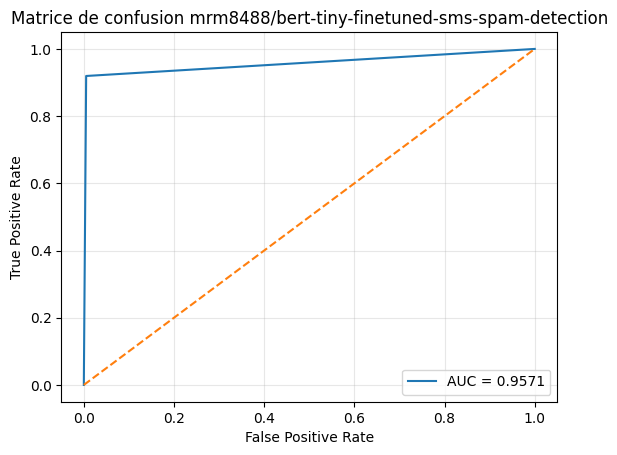

In [37]:
print("Evaluation du modèle : {checkpoint3}")
y_true3 = spam_test_df['label']
y_score3 = spam_preds['label']
print(classification_report(y_true3, y_score3))
# Evaluation de cette classification binaire ROC et AUC
fpr3, tpr3, thresholds3 = roc_curve(y_true3, y_score3)
roc_auc3 = auc(fpr3, tpr3)
plt.figure()
plt.plot(fpr3, tpr3, label=f"AUC = {roc_auc3:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.title(f"Matrice de confusion {checkpoint3}")
plt.show()

In [38]:
cm3 = pd.DataFrame(confusion_matrix(y_true3, y_score3),
                  index=['ham',  'spam'],
                  columns=['ham',  'spam'])

px.imshow(cm3, text_auto=True)

## Rapport sur le développement d'un détecteur de spam

L'objectif du détecteur de spam est de ne pas laisser passer de spam. En effet, les spams deviennent de plue en plus agressif et se transforme maintenant en action de Phishing pouvant compromettre dans le pire des cas des intégrités d'entreprise.  

Il est donc preferable d'avoir un sms de classé dans les spams même s'il est correct plutôt que laisser passer un spam comme un sms correct (HAM), le pouvoir destructeur d'un SPAM étant bien trop grave.

Au cours de cette étude, nous avons étudié 3 modèles de LLM pour résoudre le problème de l'identification de SPAM dans des SMS.
Tous s'appuient sur un modèle de langage robuste et éprouvé : BERT.  
Nous avons "fine-tuné" deux modèles ("bert-base-uncased" et "AventIQ-AI/bert-spam-detection" de la base Hugging Face) et utilisé directement sans le fine-tuné un modèle de la communauté Hugging Face déjà prêt à l'emploi pour les spam 

Le modèle BERT, "fine-tuné" sur notre dataset donne un très bon résultats avec le Dataset d'étude.
AUC quasi parfait ()
La distinction entre Spam et Ham est quasiment parfaite.  
Sur le jeu de test en ne retenant que 64 tokens par message:

- 6 faux positifs seulement
- 2 faux négatifs
Les performances sont résumées ci-dessous.

|             | precision  |  recall |f1-score  | support |
|-------------|------------|---------|----------|-------|
|   HAM       |     0.99   |   1.00  |   1.00   |    966|
|   SPAM      |     0.99   |   0.96  |   0.97   |    149|
|    accuracy |            |         |   0.99   |   1115|
|   macro avg |     0.99   |   0.98  |   0.98   |   1115|
|weighted avg |     0.99   |   0.99  |   0.99   |   1115|


On a la matrice de confusion suivante :
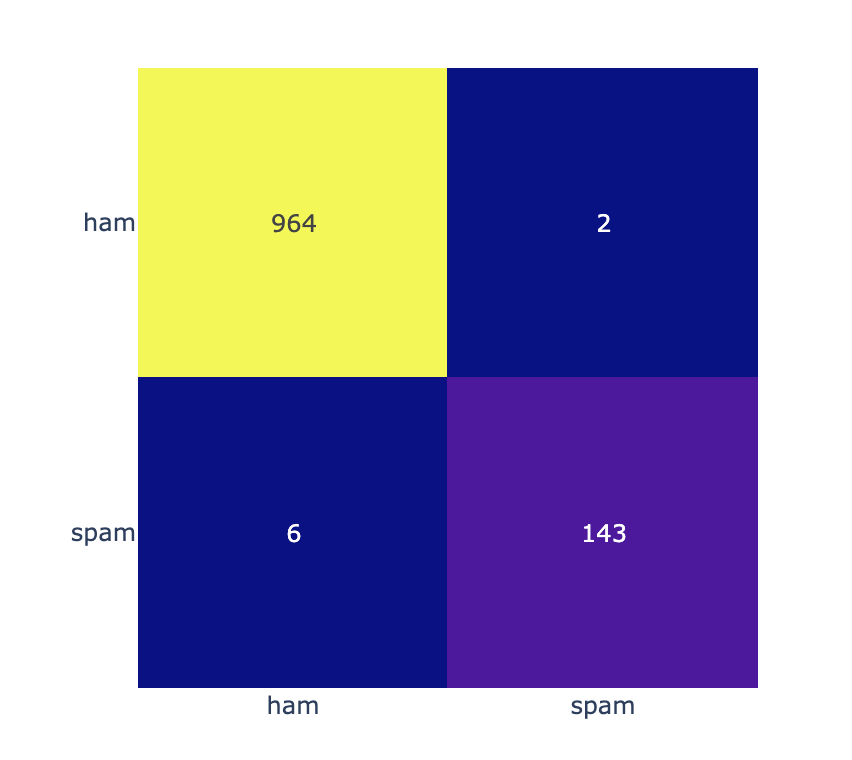
Nous faisons ainsi mieux que le modèle de détecteur de SPAM sur 64 tokens "mrm8488/bert-tiny-finetuned-sms-spam-detection".  
Ce résultat tient principalement à la qualité du modèle BERT sous jacent utilisé pour notre "raffinement".

---

### Points forts

BERT, même s'il est généraliste, est un modèle entrainé par Google sur des quantités énorme de corpus de texte avec une infrastructure tout aussi énorme de traitement.

Il capte donc efficacement :

- Le **contexte global**
- La **structure syntaxique**
- Les **intentions lexicales**
- Les **variations orthographiques typiques du SPAM**

Il est particulièrement performant pour détecter des **signaux faibles**, même dans des SMS courts, où les indices sont parfois subtils.

---

### Limites identifiées

Vu l'efficacité du modèel de LLM  nous n'avons pas étudie de réseua récurrent de type LSTM qui naguère, étaient les plus performants. Il est reconnu qu'aujourd'hui qu'ils ne font plus le poids face au LLM principalement (grâce au concept d'attention).
Cependant, le Modèle est plus lourd qu’un LSTM → **temps d’inférence plus long**,  
plus exigeant en ressources, **GPU recommandé à grande échelle**

---

### Recommandations opérationnelles pour AT&T

Pour maximiser la chance d'intercepter des SPAM même au détriment de quelques HAM

- **Seuil plus bas** → priorité à la détection SPAM  
- **Seuil plus haut** → priorité à la réduction des faux positifs  

---
Il est important de réentrainer périodiquement (mensuellement ou trimestriellement) la base de SPAM pour que le modèle reste à la pointes des techniques émergentes de SPAM notamment pour les message de trype Phishing très destructeurs.

- Collecte des SMS mal classés  
- Enrichissement progressif du dataset interne  
- Ré-entraînement mensuel ou trimestriel  

---

### Conclusion

BERT tuné est notre choix pour obtenir une détection du SPAM d'excellente qualité.